## Transfer Learning Example for OCT Classification

*pip install tensorflow keras numpy matplotlib scikit-learn*

Goal: Train a model to take OCT retinal scans and classify them into one of four conditions:


1. CNV: Choroidal neovascularization (abnormal vasucalization in the choroid
2. DME: Diabetic macular edema
3. DRUSEN: Yellow deposits under the retina, an early sign of AMD
4. NORMAL

Clinical Difference between the classes: 

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kermany2018


Take some reference images from each condition

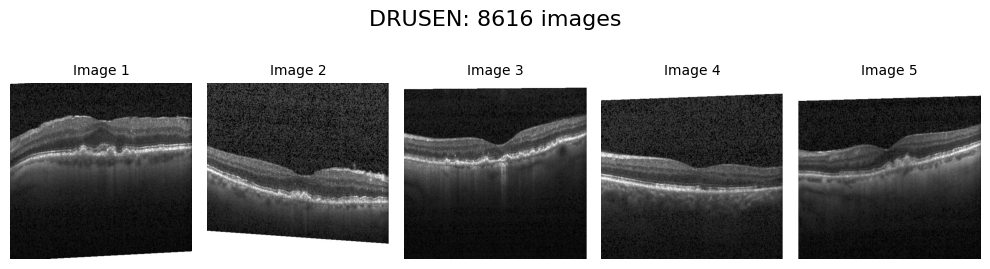

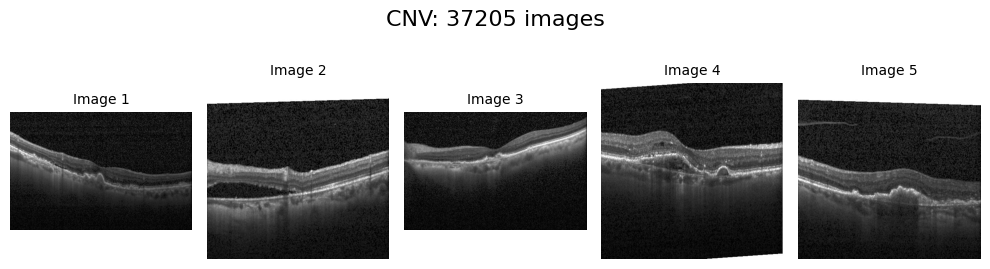

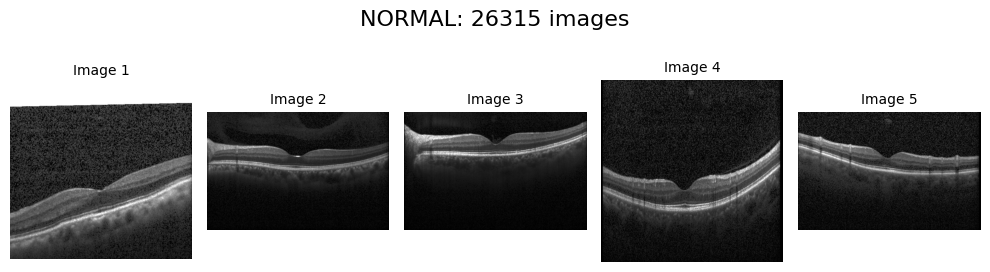

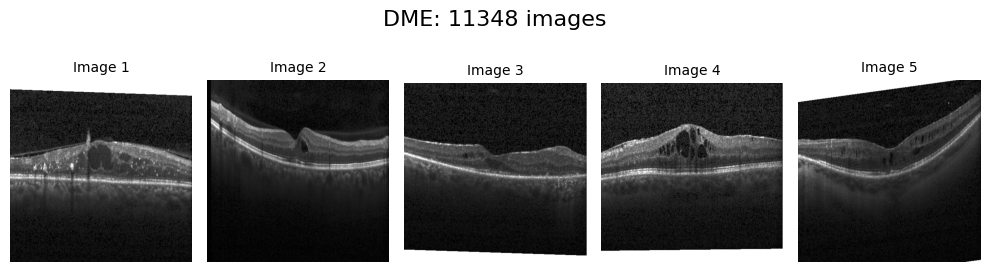

In [2]:
import os
import matplotlib.pyplot as plt
import cv2

train_path = ("/kaggle/input/kermany2018/OCT2017 /train")

# In the OCT2017 dir, 4 folders (CND, DME, DRUSEN, NORMAL)
for category in os.listdir(train_path):
    image_directory = os.path.join(train_path, category) # category = conditions (folder names in dataset)
    images = os.listdir(image_directory)[:5] # list of irectories path/CNV...

    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    fig.suptitle(f"{category}: {len(os.listdir(image_directory))} images", fontsize=16) # Number of iamges in the train data set for each condition
    
    for i, file_name in enumerate(images):
        img_path = os.path.join(image_directory, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}", fontsize=10)

    plt.tight_layout()
    plt.show()

Images are not similar size, non standard "shape". Lets trim them down to a consistent size...

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-27 23:48:30.300914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748389710.508962      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748389710.568643      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [5]:
# For easier processing, pixel values are being normalized to a value between 0 and 1 from 0 and 256.
# images are augmented: rotated, scaled, stretched, or flipped
train_datagen = ImageDataGenerator(
                                    rescale            = 1./255,
                                    rotation_range     = 5,
                                    zoom_range         = 0.1,
                                    width_shift_range  = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip    = True
                                   )

train_generator = train_datagen.flow_from_directory(
                                                     train_path,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     shuffle=False
                                                    )

Found 83484 images belonging to 4 classes.


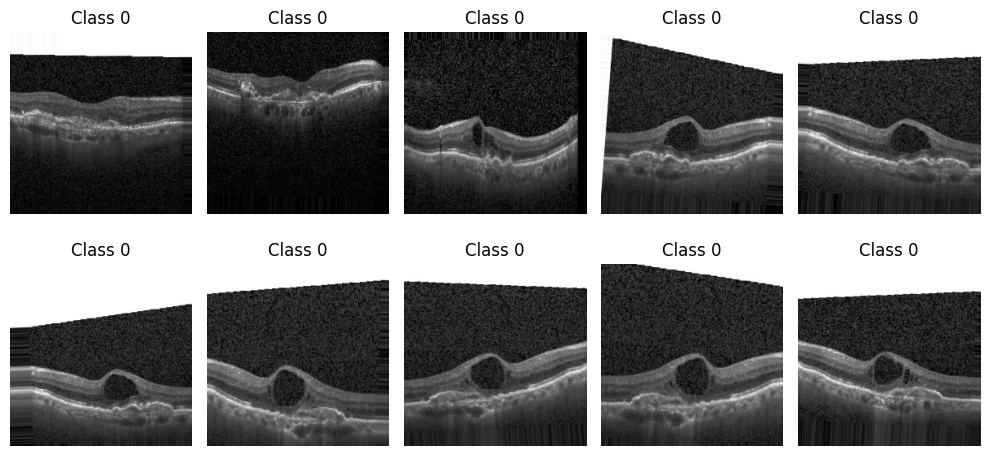

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 10 images in the batch
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Class {labels[i].argmax()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Build an efficient, lightweight, and accurate model. Goal is image classficiation.

In [7]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')

import tensorflow as tf

# Wrap generator with preprocessing layer because I plan on using EfficientNet
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
)

Found 83484 images belonging to 4 classes.


I0000 00:00:1748389785.119513      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Build the model using trasnfer learning. Use Keras > EfficientNetB0 for image processing

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
base_model = EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights=None # not ideal but the URL is not connecting
)
base_model.trainable = False  # Freeze base temporarily to use as feature extractor from OCT images

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
val_path = "/kaggle/input/kermany2018/OCT2017 /val"

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important if you want to analyze predictions
)


Found 32 images belonging to 4 classes.


In [12]:
EPOCHS = 10

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1748389805.363217     113 service.cc:148] XLA service 0x7ec6f8003370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748389805.364103     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748389807.271847     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2608 ━━━━━━━━━━━━━━━━━━━━ 20:18:12 28s/step - accuracy: 0.5000 - loss: 1.3863

I0000 00:00:1748389816.994315     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2608/2608 ━━━━━━━━━━━━━━━━━━━━ 1257s 471ms/step - accuracy: 0.4441 - loss: 1.2432 - val_accuracy: 0.2500 - val_loss: 1.5855
Epoch 2/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.3438 - loss: 1.3879 - val_accuracy: 0.2500 - val_loss: 1.5847
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2608/2608 ━━━━━━━━━━━━━━━━━━━━ 1036s 397ms/step - accuracy: 0.4458 - loss: 1.2324 - val_accuracy: 0.2500 - val_loss: 1.5814
Epoch 4/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.5625 - loss: 1.1242 - val_accuracy: 0.2500 - val_loss: 1.5818
Epoch 5/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 1050s 403ms/step - accuracy: 0.4462 - loss: 1.2299 - val_accuracy: 0.2500 - val_loss: 1.5746
Epoch 6/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.3750 - loss: 1.2721 - val_accuracy: 0.2500 - val_loss: 1.5730
Epoch 7/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 1048s 402ms/step - accuracy: 0.4470 - loss: 1.2282 - val_accuracy: 0.2500 - val_loss: 1.5921
Epoch 8/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.4375 - loss: 1.2547 - val_accuracy: 0.2500 - val_loss: 1.5923
Epoch 9/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 1021s 391ms/step - accuracy: 0.4477 - loss: 1.2268 - val_accuracy: 0.2500 - val_loss: 1.5500
Epoch 10/10
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.4062 - l

Visualize Training Curves

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


NameError: name 'history' is not defined

In [14]:
try:
    print(history.history.keys())
except Exception as e:
    print("No history object:", e)


No history object: name 'history' is not defined


In [16]:
model.save('oct_model.h5')


In [17]:
from tensorflow.keras.models import load_model
model = load_model('oct_model.h5')


In [18]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.2500 - loss: 1.5490
Validation Accuracy: 0.2500


In [21]:
test_path = "/kaggle/input/kermany2018/OCT2017 /test"

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important if you want to analyze predictions
)


Found 968 images belonging to 4 classes.


In [22]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Found 968 images belonging to 4 classes.
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.5657 - loss: 1.3166
Test Accuracy: 0.2500


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step


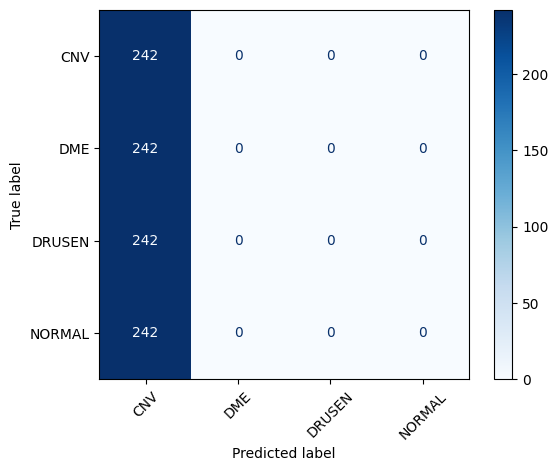

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get ground truth and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Labels
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
